In [2]:
from config import API_KEY
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt


In [3]:
# Data Collection
from tiingo import TiingoClient
from datetime import datetime, timedelta

config = {
    'api_key': API_KEY,
    'session': True  # Use requests.Session
}
client = TiingoClient(config)

# Calculate the start date as today's date minus 2 years
end_date = datetime.now()
start_date = end_date - timedelta(days=20*365)

# Convert dates to string format
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

df = client.get_dataframe('MSFT', frequency='daily',startDate=start_date_str, endDate=end_date_str)

In [4]:
# change time period to business days
df.index = pd.to_datetime(df.index).to_period('B')

df.index


c:\Users\alyss\anaconda3\envs\pycaret\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


PeriodIndex(['2004-02-25', '2004-02-26', '2004-02-27', '2004-03-01',
             '2004-03-02', '2004-03-03', '2004-03-04', '2004-03-05',
             '2004-03-08', '2004-03-09',
             ...
             '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08',
             '2024-02-09', '2024-02-12', '2024-02-13', '2024-02-14',
             '2024-02-15', '2024-02-16'],
            dtype='period[B]', name='date', length=5030)

In [5]:
# get index range
idx = pd.period_range(min(df.index), max(df.index))
idx

PeriodIndex(['2004-02-25', '2004-02-26', '2004-02-27', '2004-03-01',
             '2004-03-02', '2004-03-03', '2004-03-04', '2004-03-05',
             '2004-03-08', '2004-03-09',
             ...
             '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08',
             '2024-02-09', '2024-02-12', '2024-02-13', '2024-02-14',
             '2024-02-15', '2024-02-16'],
            dtype='period[B]', length=5213)

In [6]:
# the days that data was not available - market was closed
df.index.symmetric_difference(idx)

PeriodIndex(['2004-04-09', '2004-05-31', '2004-06-11', '2004-07-05',
             '2004-09-06', '2004-11-25', '2004-12-24', '2005-01-17',
             '2005-02-21', '2005-03-25',
             ...
             '2023-02-20', '2023-04-07', '2023-05-29', '2023-06-19',
             '2023-07-04', '2023-09-04', '2023-11-23', '2023-12-25',
             '2024-01-01', '2024-01-15'],
            dtype='period[B]', length=183)

In [7]:
import numpy as np
# reindex and fill null values with nan
df = df.reindex(idx,fill_value=np.nan)
df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
2004-02-25,26.70,26.99,26.61,26.89,64275700.0,16.702215,16.883625,16.645916,16.821070,64275700.0,0.0,1.0
2004-02-26,26.50,26.65,26.41,26.63,66602700.0,16.577105,16.670938,16.520805,16.658427,66602700.0,0.0,1.0
2004-02-27,26.53,26.62,26.35,26.48,58266500.0,16.595872,16.652171,16.483272,16.564594,58266500.0,0.0,1.0
2004-03-01,26.70,26.72,26.50,26.65,51912300.0,16.702215,16.714726,16.577105,16.670938,51912300.0,0.0,1.0
2004-03-02,26.39,26.69,26.35,26.63,66331000.0,16.508294,16.695960,16.483272,16.658427,66331000.0,0.0,1.0


In [8]:
# forward fill so that days where the market was closed will have the stock price for the previous day
df = df.fillna(method='ffill')
df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
2004-02-25,26.70,26.99,26.61,26.89,64275700.0,16.702215,16.883625,16.645916,16.821070,64275700.0,0.0,1.0
2004-02-26,26.50,26.65,26.41,26.63,66602700.0,16.577105,16.670938,16.520805,16.658427,66602700.0,0.0,1.0
2004-02-27,26.53,26.62,26.35,26.48,58266500.0,16.595872,16.652171,16.483272,16.564594,58266500.0,0.0,1.0
2004-03-01,26.70,26.72,26.50,26.65,51912300.0,16.702215,16.714726,16.577105,16.670938,51912300.0,0.0,1.0
2004-03-02,26.39,26.69,26.35,26.63,66331000.0,16.508294,16.695960,16.483272,16.658427,66331000.0,0.0,1.0


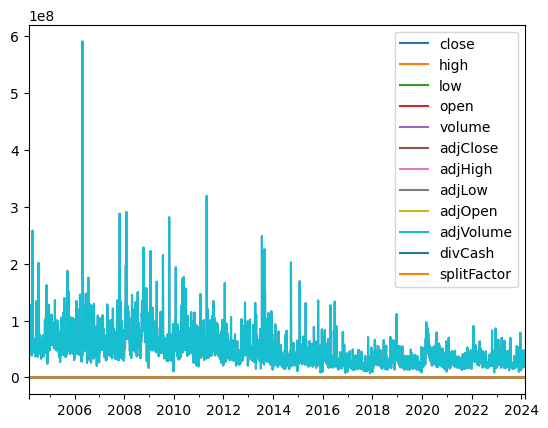

In [8]:
df.plot()
plt.show()

In [9]:
df.drop(['volume','close','high','low','open','adjVolume','divCash'],axis=1,inplace=True)
df = df[['adjClose']]
df.head()


,adjClose
2004-02-25,16.702215
2004-02-26,16.577105
2004-02-27,16.595872
2004-03-01,16.702215
2004-03-02,16.508294


In [10]:
for i in range(1, 22):  # Assuming you want to use the first 15 points to predict the next one
    df[f'lag_{i}'] = df['adjClose'].shift(i)

In [11]:
df = df.dropna()
df

,adjClose,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
2004-03-25,15.757633,15.269703,15.107060,15.326003,15.407324,15.569968,15.720100,15.751378,15.738866,15.876488,...,16.089175,16.157986,16.483272,16.495783,16.495783,16.508294,16.702215,16.595872,16.577105,16.702215
2004-03-26,15.657545,15.757633,15.269703,15.107060,15.326003,15.407324,15.569968,15.720100,15.751378,15.738866,...,15.870232,16.089175,16.157986,16.483272,16.495783,16.495783,16.508294,16.702215,16.595872,16.577105
2004-03-29,15.832699,15.657545,15.757633,15.269703,15.107060,15.326003,15.407324,15.569968,15.720100,15.751378,...,15.695078,15.870232,16.089175,16.157986,16.483272,16.495783,16.495783,16.508294,16.702215,16.595872
2004-03-30,15.763889,15.832699,15.657545,15.757633,15.269703,15.107060,15.326003,15.407324,15.569968,15.720100,...,15.876488,15.695078,15.870232,16.089175,16.157986,16.483272,16.495783,16.495783,16.508294,16.702215
2004-03-31,15.594990,15.763889,15.832699,15.657545,15.757633,15.269703,15.107060,15.326003,15.407324,15.569968,...,15.738866,15.876488,15.695078,15.870232,16.089175,16.157986,16.483272,16.495783,16.495783,16.508294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-12,414.500822,419.781151,413.352925,413.293035,404.748684,404.908391,410.468208,403.041810,396.853145,407.843017,...,404.129817,401.824041,398.170732,395.785101,397.941152,393.149928,388.757972,389.556509,387.759800,387.759800
2024-02-13,405.577167,414.500822,419.781151,413.352925,413.293035,404.748684,404.908391,410.468208,403.041810,396.853145,...,403.191536,404.129817,401.824041,398.170732,395.785101,397.941152,393.149928,388.757972,389.556509,387.759800
2024-02-14,409.490000,405.577167,414.500822,419.781151,413.352925,413.293035,404.748684,404.908391,410.468208,403.041810,...,408.970951,403.191536,404.129817,401.824041,398.170732,395.785101,397.941152,393.149928,388.757972,389.556509
2024-02-15,406.560000,409.490000,405.577167,414.500822,419.781151,413.352925,413.293035,404.748684,404.908391,410.468208,...,407.843017,408.970951,403.191536,404.129817,401.824041,398.170732,395.785101,397.941152,393.149928,388.757972


In [12]:
# Split Train Test into 80/20 ratio

pos=int(round(len(df)*(0.8)))
train=df[:pos]
test=df[pos:]
train.shape, test.shape

((4154, 22), (1038, 22))

In [13]:
lag_features = ', '.join([f'"{lag}"' for lag in df.columns if 'lag_' in lag])
print(lag_features)


"lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9", "lag_10", "lag_11", "lag_12", "lag_13", "lag_14", "lag_15", "lag_16", "lag_17", "lag_18", "lag_19", "lag_20", "lag_21"


In [14]:
# from pycaret.regression import *
# features = lag_features
# close_s = setup(data=train, test_data=test, target='adjClose', fold_strategy='timeseries', feature_selection=lag_features, data_split_shuffle=False, fold_shuffle=False, session_id=123)


In [14]:
from pycaret.time_series import *
setup(data=train, target='adjClose',fh = 7, fold = 3,seasonal_period=90, session_id = 123)

c:\Users\alyss\anaconda3\envs\pycaret\lib\site-packages\sktime\utils\validation\series.py:21: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
c:\Users\alyss\anaconda3\envs\pycaret\lib\site-packages\sktime\forecasting\base\_fh.py:18: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  RELATIVE_TYPES = (pd.Int64Index, pd.RangeIndex)
c:\Users\alyss\anaconda3\envs\pycaret\lib\site-packages\sktime\forecasting\base\_fh.py:19: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ABSOLUTE_TYPES = (pd.Int64Index, pd.RangeIndex, pd.DatetimeIndex, pd.PeriodIndex)
c:\Users\alyss\anaconda3\envs\pycaret\lib\si

,Description,Value
0,session_id,123
1,Target,adjClose
2,Approach,Univariate
3,Exogenous Variables,Present
4,Data shape,"(4154, 22)"
5,Train data shape,"(4147, 22)"
6,Test data shape,"(7, 22)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,3
9,Enforce Prediction Interval,False


In [15]:
close_best = compare_models(sort = 'R2')

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec)
arima,ARIMA,2.4659,2.9001,0.0146,0.0147,0.5825,0.4550,-0.6359,107.0767
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,5.0038,5.6236,0.0293,0.0300,1.1809,0.8818,-4.1320,3.3200
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,3.5937,4.5457,0.0211,0.0214,0.8483,0.7123,-4.2022,3.1767
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,5.0837,5.6740,0.0297,0.0304,1.1992,0.8889,-5.2511,4.5300
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,5.2881,5.9073,0.0309,0.0317,1.2476,0.9256,-5.4159,4.1100
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,5.3008,5.9187,0.0310,0.0318,1.2506,0.9274,-5.4227,0.5400
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,5.4998,6.1330,0.0321,0.0329,1.2972,0.9606,-6.3131,1.4333
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,5.3616,5.9250,0.0313,0.0320,1.2643,0.9275,-6.3774,3.5800
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,5.0815,5.9854,0.0297,0.0304,1.1989,0.9388,-6.4758,3.1400
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,5.3709,5.9752,0.0313,0.0320,1.2663,0.9352,-7.7272,82.1933


In [ ]:
prediction = predict_model(close_best, fh = 90)
prediction.head(60)
